# Graphical monitoring of training 

In [240]:
import re
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [241]:
LOGFILE = "../HR,SpO2,InvBPSys,InvBPDias,RRtotal-30-rnn-128-3-0.5.log"

In [242]:
batches = []
epochs = []
with open(LOGFILE, "r") as f:
    for _ in range(3): next(f)
    for line in f:
        m = re.match("(batch|epoch)\s+([^\s]+):\s+train loss:\s+([^\s]+)"
                     "(\s+validation loss:\s+([^\s]+)\s+test loss:\s+([^\s]+)\s+average std:\s+([^\s]+))?",
                     line)
        if m:
            if m[1] == "batch":
                batches.append(float(m[3]))
            elif m[1] == "epoch":
                epochs.append([float(x) for x in [m[3], m[5], m[6], m[7]]])

Per batch training loss should go down noisily. First batches are bullshit, drop them.

In [243]:
INCREMENTAL = True
if INCREMENTAL:
    BURNIN = 0.1
else:
    BURNIN = 0

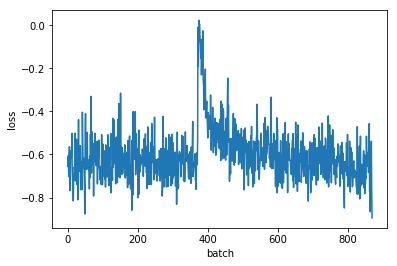

In [244]:
plt.plot(batches[int(BURNIN*len(batches)):])
plt.xlabel("batch")
plt.ylabel("loss")
if not INCREMENTAL:
    plt.ylim((-2, 2))
plt.show()

Let's look at test loss. It should go down, and be about the same as train loss.

(array([-0.613694, -0.598319]), array([-0.277074, -0.688482]))

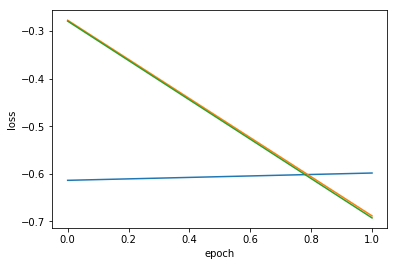

In [245]:

plt.plot(numpy.array(epochs[int(BURNIN*len(epochs)):])[:, :3])
plt.xlabel("epoch")
plt.ylabel("loss")
if not INCREMENTAL:
    plt.ylim((-2, 2))
(numpy.array(epochs)[-10:, 0],
numpy.array(epochs)[-10:, 1])

Now the interesting thing is the standard deviation.

array([ 0.57161 ,  0.463397])

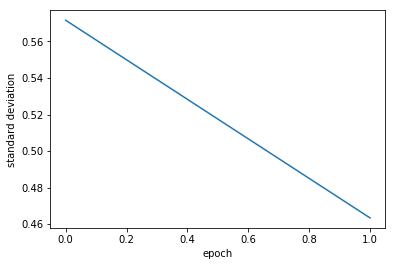

In [246]:
plt.plot(numpy.array(epochs)[:, 3])
plt.xlabel("epoch")
plt.ylabel("standard deviation")
numpy.array(epochs)[-10:,3]

The standard deviation first goes up and then down until stabilizes. Speculating about this, for the model it is first easier to increase variance and get some predictions with low confidence, and then tighten up the confidence while improving predictions.

A good question is what is the standard deviation of differences. Let's check it on one of our data sets.

In [247]:
data = numpy.load("/var/data/monitor/data/HR,SpO2,InvBPSys,InvBPDias,RRtotal/array")
# data = numpy.load("../data/HR/array")
data.shape

(137142, 60, 5)

In [248]:
diffs = data[:, 1:, :] - data[:, :-1, :]
diffs.mean()  # should be close to zero

-0.00034084339963213106

In [249]:
numpy.sqrt((diffs * diffs).sum(0).sum(0)/(diffs.shape[0]*diffs.shape[1]))

array([ 0.3152723 ,  0.47223542,  0.28671769,  0.35939817,  0.47387339])

If our network learns to predict better than that, things are not that bad. 